## GNR 650 - Advanced topics in deep learning for image analysis
### Assignment 1: ResNet-18 on CIFAR10 with few training samples per class
> The task is to take the structure of ResNet-18 model, and train it from scratch on CIFAR10 data, but take very few samples per class. After training, check the test performance. Check the magnitudes of the weights, visualize the kernels at different layers.

### Imporing Libraries

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

### Hyperparameters

In [9]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
inv_mean = -mean
inv_std = 1/std
max_n = 100
batch_size = 32
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 40
print_summary = False

### Preprocessing & Data Augmentation

In [3]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

# For the purposes of visualizing images
inv_transforms = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                          std = inv_std),
                                     transforms.Normalize(mean = inv_mean,
                                                          std = (1., 1., 1,))])

cifar10 = datasets.CIFAR10(root = './data/', train=True, transform=train_transforms, download=True)
cifar10_test = datasets.CIFAR10(root='./data/', train=False, transform=test_transforms, download=True)
cifar10_classes = cifar10.classes
images, labels = cifar10.data, np.array(cifar10.targets)
test_images, test_labels = cifar10_test.data, np.array(cifar10_test.targets)

Files already downloaded and verified
Files already downloaded and verified


### Visualizing CIFAR 10 Dataset

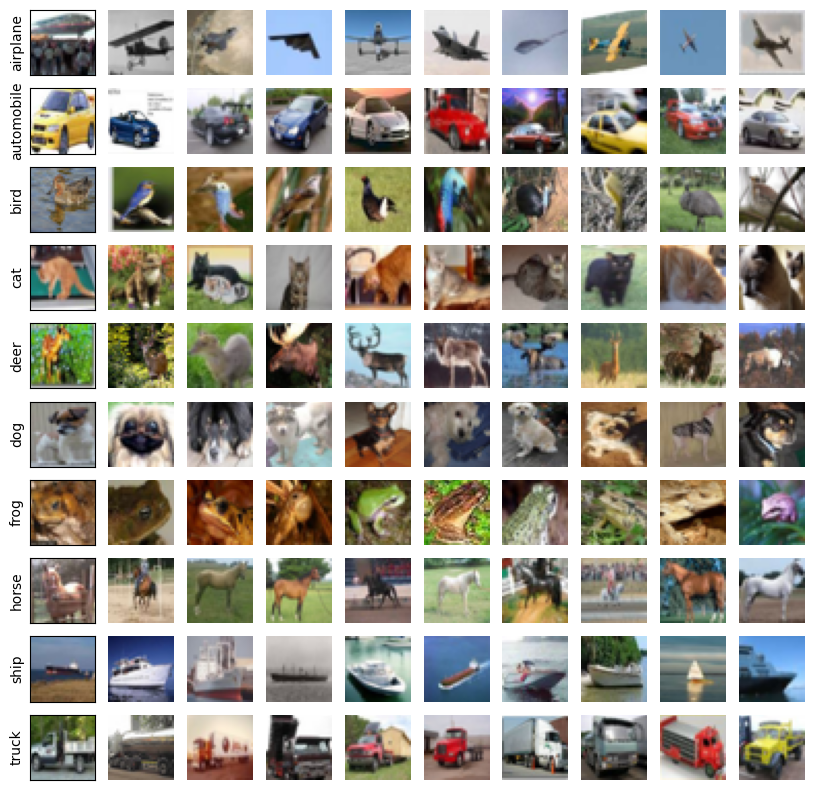

In [4]:
num_per_class = 10
fig, axes = plt.subplots(nrows=num_per_class, ncols=len(cifar10_classes), figsize = (10,10))
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    for row in range(num_per_class):
        disp_idx = random.choice(lbl_idxs)
        img = images[disp_idx]
        axes[idx][row].imshow(img)
        if row == 0:
            axes[idx][row].set_ylabel(cls_name)
            axes[idx][row].set_xticks([])
            axes[idx][row].set_yticks([])
            continue
        axes[idx][row].axis('off')

### Preparing Datasets: Subset & Full

In [5]:
data_idxs_subset = []                           # 100 training images per class
data_idxs_full = []                             # 5000 training images per class
for idx, _ in enumerate(cifar10_classes):   
    lbl_idxs = np.where(labels == idx)[0]
    idxs_subset = np.random.choice(lbl_idxs, max_n, replace=False)
    data_idxs_subset.extend(idxs_subset)
    data_idxs_full.extend(lbl_idxs)
print("Size of subset dataset: ", len(data_idxs_subset))        # 100 x 10 = 1000
print("Size of full dataset: ", len(data_idxs_full))            # 5000 x 10 = 50000

Size of subset dataset:  1000
Size of full dataset:  50000


### Preparing CIFAR 10 Dataloader

In [6]:
class Cifar10(Dataset):
    def __init__(self, images, labels, idxs, transform = None):
        self.images = images[idxs]
        self.labels = labels[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            if not isinstance(img, torch.Tensor):
                img = Image.fromarray(img)
                img = self.transform(img)
        return img, lbl
    
# Create two datasets, one for subset and one for full
train_dataset_subset = Cifar10(images, labels, data_idxs_subset, train_transforms)
train_dataset_full = Cifar10(images, labels, data_idxs_full, train_transforms)
test_dataset = Cifar10(test_images, test_labels, list(range(len(test_images))), test_transforms)
 
# Create DataLoaders
trainloader_subset = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
trainloader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

### Training Function

In [7]:
def train_model(trainloader, model_name, print_summary):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(cifar10_classes))
    model = model.to(device)
    if print_summary:
        summary(model=model, input_size=(3,32,32))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    accuracy = []
    print(f"Training {model_name}")
    for epoch in range(1, epochs+1):
        pbar = tqdm(trainloader, total=len(trainloader), leave=False)
        epoch_loss = 0.0
        model.train()
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(train_loss=loss.item())

        epoch_loss = epoch_loss / len(trainloader)
        model.eval()
        no_of_correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in trainloader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                _, preds = out.max(-1)
                no_of_correct += (preds == lbls).cpu().numpy().sum()
                total += len(lbls)

        epoch_accuracy = no_of_correct / total
        losses.append(epoch_loss)
        accuracy.append(epoch_accuracy)
        print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_loss:5.3f}, Train Accuracy: {epoch_accuracy*100:5.2f}
{"#"*33}''')
    return model,losses,accuracy

### Training ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)

In [10]:
resnet18_subset, losses_subset, accuracy_subset = train_model(trainloader_subset, "ResNet18 Subset", print_summary=print_summary)

Training ResNet18 Subset


********** EPOCH  1/40 **********
#################################
Train Loss: 2.311, Train Accuracy: 30.90
#################################


********** EPOCH  2/40 **********
#################################
Train Loss: 1.771, Train Accuracy: 53.50
#################################


********** EPOCH  3/40 **********
#################################
Train Loss: 1.475, Train Accuracy: 52.30
#################################


********** EPOCH  4/40 **********
#################################
Train Loss: 1.182, Train Accuracy: 73.00
#################################


********** EPOCH  5/40 **********
#################################
Train Loss: 0.986, Train Accuracy: 76.40
#################################


********** EPOCH  6/40 **********
#################################
Train Loss: 0.995, Train Accuracy: 77.80
#################################


********** EPOCH  7/40 **********
#################################
Train Loss: 0.697, Train Accuracy: 87.30
#################################


********** EPOCH  8/40 **********
#################################
Train Loss: 0.515, Train Accuracy: 92.30
#################################


********** EPOCH  9/40 **********
#################################
Train Loss: 0.395, Train Accuracy: 93.60
#################################


********** EPOCH 10/40 **********
#################################
Train Loss: 0.522, Train Accuracy: 81.50
#################################


********** EPOCH 11/40 **********
#################################
Train Loss: 0.606, Train Accuracy: 91.20
#################################


********** EPOCH 12/40 **********
#################################
Train Loss: 0.299, Train Accuracy: 97.80
#################################


********** EPOCH 13/40 **********
#################################
Train Loss: 0.274, Train Accuracy: 95.80
#################################


********** EPOCH 14/40 **********
#################################
Train Loss: 0.288, Train Accuracy: 93.10
#################################


********** EPOCH 15/40 **********
#################################
Train Loss: 0.342, Train Accuracy: 95.90
#################################


********** EPOCH 16/40 **********
#################################
Train Loss: 0.227, Train Accuracy: 96.80
#################################


********** EPOCH 17/40 **********
#################################
Train Loss: 0.199, Train Accuracy: 97.40
#################################


********** EPOCH 18/40 **********
#################################
Train Loss: 0.235, Train Accuracy: 97.30
#################################


********** EPOCH 19/40 **********
#################################
Train Loss: 0.237, Train Accuracy: 98.30
#################################


********** EPOCH 20/40 **********
#################################
Train Loss: 0.205, Train Accuracy: 97.70
#################################


********** EPOCH 21/40 **********
#################################
Train Loss: 0.138, Train Accuracy: 99.40
#################################


********** EPOCH 22/40 **********
#################################
Train Loss: 0.114, Train Accuracy: 98.20
#################################


********** EPOCH 23/40 **********
#################################
Train Loss: 0.081, Train Accuracy: 99.80
#################################


********** EPOCH 24/40 **********
#################################
Train Loss: 0.098, Train Accuracy: 99.70
#################################


********** EPOCH 25/40 **********
#################################
Train Loss: 0.172, Train Accuracy: 96.80
#################################


********** EPOCH 26/40 **********
#################################
Train Loss: 0.215, Train Accuracy: 97.00
#################################


********** EPOCH 27/40 **********
#################################
Train Loss: 0.155, Train Accuracy: 99.30
#################################


********** EPOCH 28/40 **********
#################################
Train Loss: 0.114, Train Accuracy: 99.80
#################################


********** EPOCH 29/40 **********
#################################
Train Loss: 0.156, Train Accuracy: 98.50
#################################


********** EPOCH 30/40 **********
#################################
Train Loss: 0.123, Train Accuracy: 99.40
#################################


********** EPOCH 31/40 **********
#################################
Train Loss: 0.144, Train Accuracy: 99.60
#################################


********** EPOCH 32/40 **********
#################################
Train Loss: 0.141, Train Accuracy: 99.70
#################################


********** EPOCH 33/40 **********
#################################
Train Loss: 0.186, Train Accuracy: 98.80
#################################


********** EPOCH 34/40 **********
#################################
Train Loss: 0.070, Train Accuracy: 99.70
#################################


********** EPOCH 35/40 **********
#################################
Train Loss: 0.029, Train Accuracy: 99.90
#################################


********** EPOCH 36/40 **********
#################################
Train Loss: 0.023, Train Accuracy: 100.00
#################################


********** EPOCH 37/40 **********
#################################
Train Loss: 0.015, Train Accuracy: 100.00
#################################


********** EPOCH 38/40 **********
#################################
Train Loss: 0.033, Train Accuracy: 99.90
#################################


********** EPOCH 39/40 **********
#################################
Train Loss: 0.055, Train Accuracy: 99.60
#################################


********** EPOCH 40/40 **********
#################################
Train Loss: 0.035, Train Accuracy: 100.00
#################################


### Training ResNet-18 on CIFAR10 Full Dataset

In [11]:
resnet18_full, losses_full, accuracy_full = train_model(trainloader_full, "ResNet18 Full", print_summary=print_summary)

Training ResNet18 Full


********** EPOCH  1/40 **********
#################################
Train Loss: 1.415, Train Accuracy: 57.50
#################################


********** EPOCH  2/40 **********
#################################
Train Loss: 1.012, Train Accuracy: 69.93
#################################


********** EPOCH  3/40 **********
#################################
Train Loss: 0.827, Train Accuracy: 76.57
#################################


********** EPOCH  4/40 **********
#################################
Train Loss: 0.700, Train Accuracy: 82.26
#################################


********** EPOCH  5/40 **********
#################################
Train Loss: 0.597, Train Accuracy: 83.96
#################################


********** EPOCH  6/40 **********
#################################
Train Loss: 0.496, Train Accuracy: 86.41
#################################


********** EPOCH  7/40 **********
#################################
Train Loss: 0.405, Train Accuracy: 92.01
#################################


********** EPOCH  8/40 **********
#################################
Train Loss: 0.327, Train Accuracy: 92.77
#################################


********** EPOCH  9/40 **********
#################################
Train Loss: 0.260, Train Accuracy: 95.79
#################################


********** EPOCH 10/40 **********
#################################
Train Loss: 0.211, Train Accuracy: 95.67
#################################


********** EPOCH 11/40 **********
#################################
Train Loss: 0.175, Train Accuracy: 97.11
#################################


********** EPOCH 12/40 **********
#################################
Train Loss: 0.159, Train Accuracy: 97.23
#################################


********** EPOCH 13/40 **********
#################################
Train Loss: 0.134, Train Accuracy: 97.14
#################################


********** EPOCH 14/40 **********
#################################
Train Loss: 0.117, Train Accuracy: 98.17
#################################


********** EPOCH 15/40 **********
#################################
Train Loss: 0.105, Train Accuracy: 98.59
#################################


********** EPOCH 16/40 **********
#################################
Train Loss: 0.092, Train Accuracy: 98.09
#################################


********** EPOCH 17/40 **********
#################################
Train Loss: 0.090, Train Accuracy: 98.57
#################################


********** EPOCH 18/40 **********
#################################
Train Loss: 0.088, Train Accuracy: 98.67
#################################


********** EPOCH 19/40 **********
#################################
Train Loss: 0.079, Train Accuracy: 98.81
#################################


********** EPOCH 20/40 **********
#################################
Train Loss: 0.070, Train Accuracy: 99.01
#################################


********** EPOCH 21/40 **********
#################################
Train Loss: 0.071, Train Accuracy: 97.87
#################################


********** EPOCH 22/40 **********
#################################
Train Loss: 0.065, Train Accuracy: 99.13
#################################


********** EPOCH 23/40 **********
#################################
Train Loss: 0.061, Train Accuracy: 98.47
#################################


********** EPOCH 24/40 **********
#################################
Train Loss: 0.056, Train Accuracy: 99.28
#################################


********** EPOCH 25/40 **********
#################################
Train Loss: 0.063, Train Accuracy: 99.49
#################################


********** EPOCH 26/40 **********
#################################
Train Loss: 0.052, Train Accuracy: 98.18
#################################


********** EPOCH 27/40 **********
#################################
Train Loss: 0.057, Train Accuracy: 99.06
#################################


********** EPOCH 28/40 **********
#################################
Train Loss: 0.045, Train Accuracy: 99.20
#################################


********** EPOCH 29/40 **********
#################################
Train Loss: 0.045, Train Accuracy: 99.25
#################################


********** EPOCH 30/40 **********
#################################
Train Loss: 0.045, Train Accuracy: 99.14
#################################


********** EPOCH 31/40 **********
#################################
Train Loss: 0.048, Train Accuracy: 99.38
#################################


********** EPOCH 32/40 **********
#################################
Train Loss: 0.036, Train Accuracy: 99.54
#################################


********** EPOCH 33/40 **********
#################################
Train Loss: 0.041, Train Accuracy: 99.41
#################################


********** EPOCH 34/40 **********
#################################
Train Loss: 0.046, Train Accuracy: 99.03
#################################


********** EPOCH 35/40 **********
#################################
Train Loss: 0.037, Train Accuracy: 99.49
#################################


********** EPOCH 36/40 **********
#################################
Train Loss: 0.039, Train Accuracy: 99.27
#################################


********** EPOCH 37/40 **********
#################################
Train Loss: 0.037, Train Accuracy: 99.63
#################################


********** EPOCH 38/40 **********
#################################
Train Loss: 0.034, Train Accuracy: 99.15
#################################


********** EPOCH 39/40 **********
#################################
Train Loss: 0.036, Train Accuracy: 99.36
#################################


********** EPOCH 40/40 **********
#################################
Train Loss: 0.039, Train Accuracy: 99.51
#################################


### Testing Function

In [12]:
def test_model(testloader, model):
    model.eval()
    no_of_correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in testloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            _, preds = out.max(-1)
            no_of_correct += (preds == lbls).cpu().numpy().sum()
            total += len(lbls)

    test_accuracy = no_of_correct / total
    return test_accuracy

### Comparing Training Set Performance

In [13]:
training_accuracy_subset = accuracy_subset[-1] if accuracy_subset else 0
training_accuracy_full = accuracy_full[-1] if accuracy_full else 0
print(f"Training Accuracy of ResNet18 on subset CIFAR10 Dataset: {training_accuracy_subset * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on full CIFAR10 Dataset: {training_accuracy_full * 100:.2f}%")

Training Accuracy of ResNet18 on subset CIFAR10 Dataset: 100.00%
Training Accuracy of ResNet18 on full CIFAR10 Dataset: 99.51%


### Comparing Test Set Performance

In [14]:
test_accuracy_subset = test_model(testloader, resnet18_subset)
test_accuracy_full = test_model(testloader, resnet18_full)
print(f"Test Accuracy of ResNet18 on subset CIFAR10 Dataset: {test_accuracy_subset * 100:.2f}%")
print(f"Test Accuracy of ResNet18 on full CIFAR10 Dataset: {test_accuracy_full * 100:.2f}%")

Test Accuracy of ResNet18 on subset CIFAR10 Dataset: 39.45%
Test Accuracy of ResNet18 on full CIFAR10 Dataset: 78.00%


### Plotting Training Accuracy and Training Loss

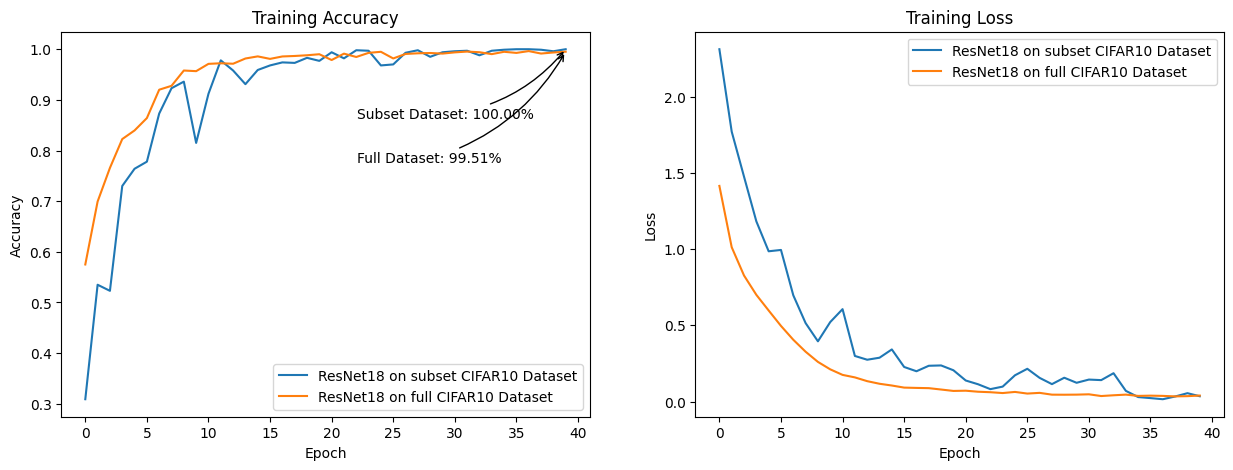

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(accuracy_subset, label="ResNet18 on subset CIFAR10 Dataset")
axes[0].plot(accuracy_full, label="ResNet18 on full CIFAR10 Dataset")
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[0].annotate(f"Subset Dataset: {training_accuracy_subset*100:.2f}%", 
                 xy=(len(accuracy_subset)-1, training_accuracy_subset), 
                 xycoords='data',
                 xytext=(-150, -50), 
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->",
                                 connectionstyle="arc3,rad=.2"))

axes[0].annotate(f"Full Dataset: {training_accuracy_full*100:.2f}%", 
                 xy=(len(accuracy_full)-1, training_accuracy_full), 
                 xycoords='data',
                 xytext=(-150, -80), 
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->",
                                 connectionstyle="arc3,rad=.2"))

axes[1].plot(losses_subset, label="ResNet18 on subset CIFAR10 Dataset")
axes[1].plot(losses_full, label="ResNet18 on full CIFAR10 Dataset")
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

### Comparing Weight Distributions

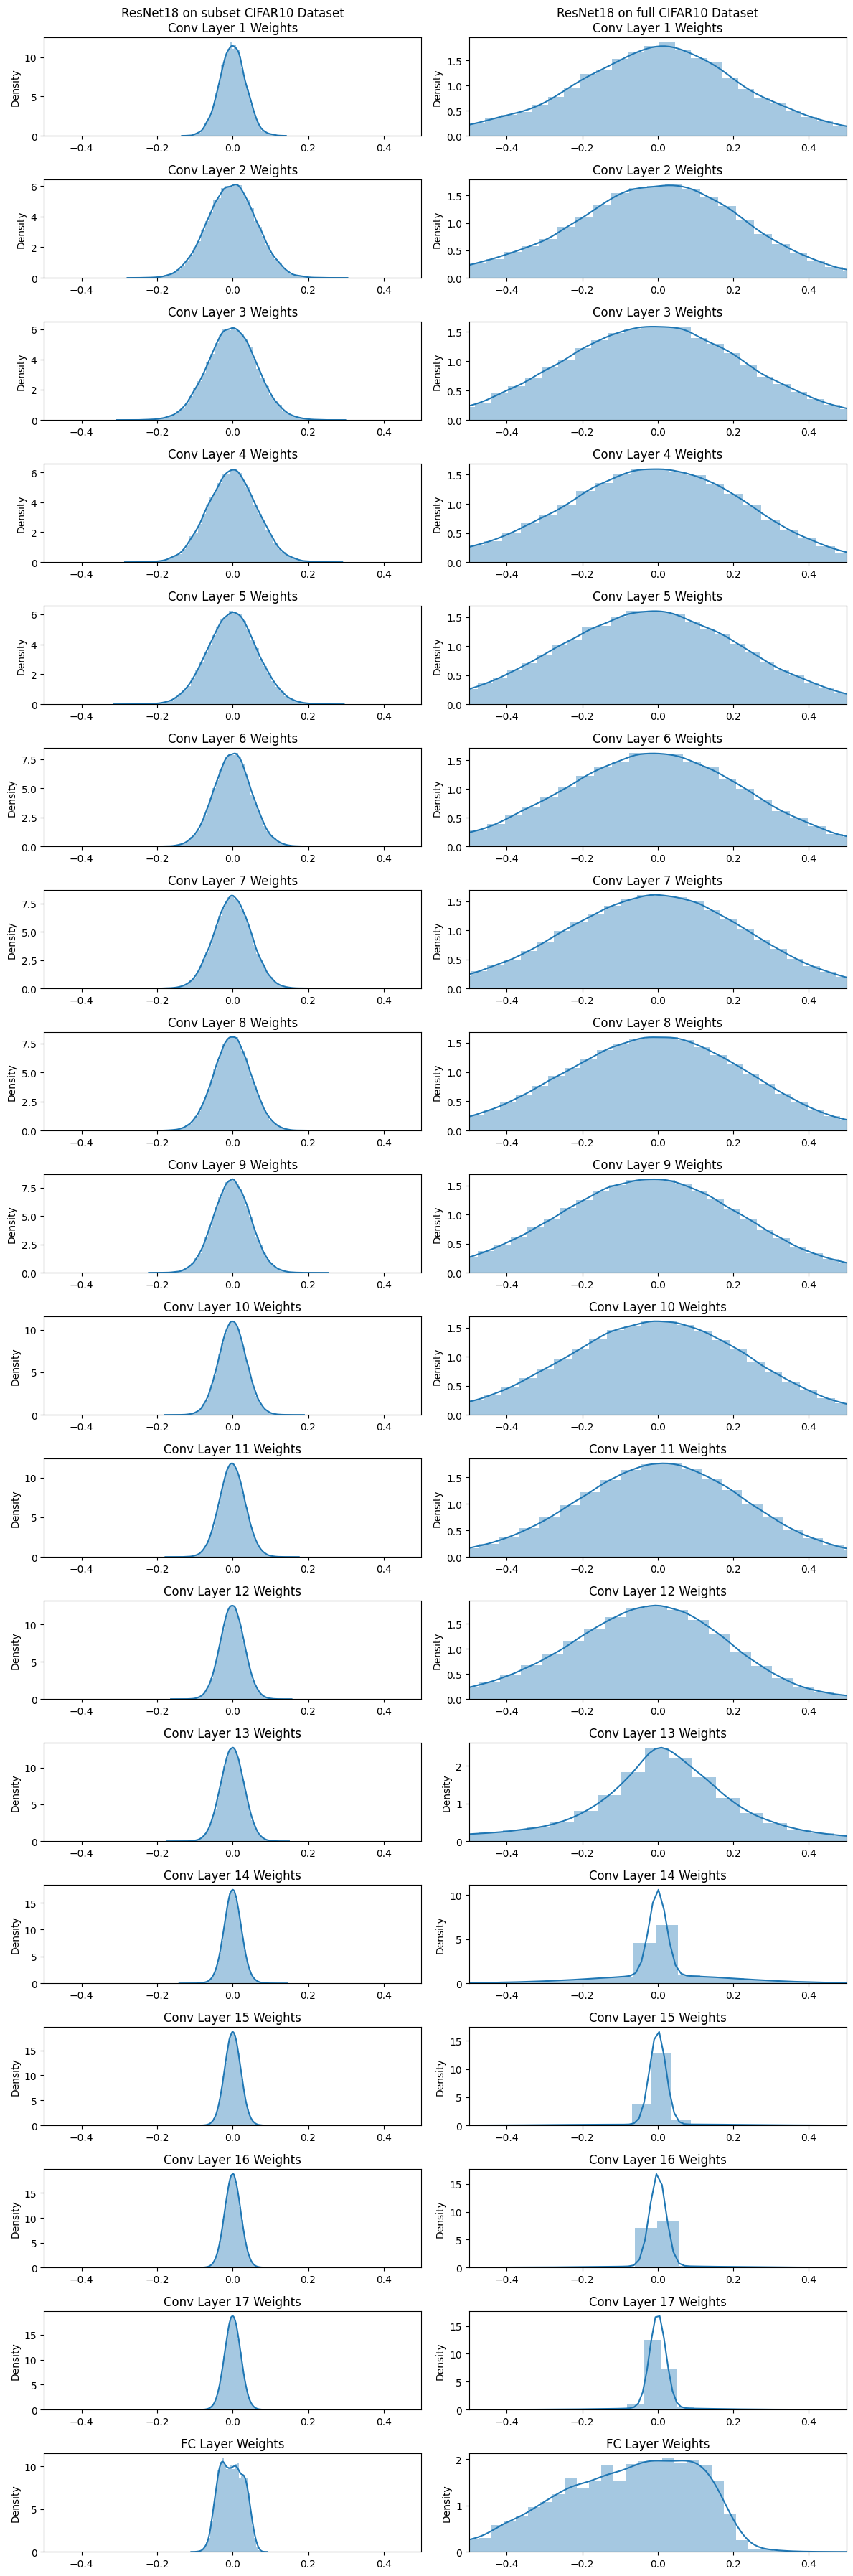

In [16]:
models = [resnet18_subset, resnet18_full]
model_names = ["ResNet18 on subset CIFAR10 Dataset", "ResNet18 on full CIFAR10 Dataset"]

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(12, 36))
conv_layer = 1

for layer_index in range(18):
    for model_index, model in enumerate(models):
        current_layer = None
        layer_count = 0
        for layer in model.named_modules():
            if layer[0].find('conv') != -1:
                if layer_count == layer_index:
                    current_layer = layer
                    break
                layer_count += 1
            elif layer[0].find('fc') != -1 and layer_index == 17:  
                current_layer = layer
                break
        
        if current_layer:
            layer_weights = current_layer[1].weight.cpu().detach().clone().numpy().reshape(-1, 1)
            if current_layer[0].find('conv') != -1:
                title = f"Conv Layer {conv_layer} Weights"
                if model_index == 1:
                    conv_layer += 1
            else:
                title = f"FC Layer Weights"
            if layer_index == 0:
                title = f"{model_names[model_index]}\n{title}"
            sns.distplot(x=layer_weights, ax=axes[layer_index, model_index]).set(title=title)
            axes[layer_index, model_index].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()